In [64]:
import tensorflow as tf
import numpy as np
import google.protobuf
from IPython.display import Audio
import matplotlib.pyplot as plt

import functools
import multiprocessing

sess = tf.Session()

In [32]:
def filename_to_example_array(data_filename):
    with multiprocessing.Pool(processes=4) as pool:
        dataset_iterator = tf.python_io.tf_record_iterator(data_filename)
        data = pool.map(tf.train.Example.FromString, dataset_iterator)
    return np.array(data)

In [5]:
def midi_pitch_to_frequency(pitch):
    '''
    pitch: int, a midi pitch
    
    returns the frequency represented by that pitch
    '''
    return np.power(2, (pitch-69)/12) * 440

def frequency_to_midi_pitch(frequency):
    '''
    frequency: float, the frequency of a note
    
    returns the closest midi pitch
    '''
    return 69 + np.round(12 * np.log2(frequency / 440))

def midi_pitch_to_note_name(pitch, flats=True):
    '''
    pitch: int, the midi number of a note
    
    returns the note name and octave
    note that no sanity checking is done on the note,
        negative numbers are interpreted as if the midi range extended that far
    '''
    if flats:
        notes = [
            'A',
            'Bb',
            'B',
            'C',
            'Db',
            'D',
            'Eb',
            'E',
            'F',
            'Gb',
            'G',
            'Ab'
        ]
    else:
        notes = [
            'A',
            'A#',
            'B',
            'C',
            'C#',
            'D',
            'D#',
            'E',
            'F',
            'F#',
            'G',
            'G#'
        ]
    
    # determined from http://newt.phys.unsw.edu.au/jw/notes.html
    
    note = notes[(pitch - 21) % len(notes)]
    octave = int(np.ceil((pitch-23) / len(notes)))
    return note + str(octave)

In [6]:
def example_to_audio(example):
    '''
    Take an Example and make it into a jupyter audio widget
    
    example: tf.train.Example containing a note
    '''
    sample_rate = example.features.feature['sample_rate'].int64_list.value[0]
    sample = example.features.feature['audio'].float_list.value
    return Audio(sample, rate=sample_rate)

In [7]:
def get_feature(datum, feature):
    '''
    Convienence function to grab a data element in the most sane type
    
    datum: tf.train.Feature from the magenta dataset
            (should have all the things in feature_conversion_map)
    
    returns the extracted value as int, str, or np.array
    
    TODO: should probably bytes.decode the items in qualities_str?
          haven't tested most of these
    '''
    def from_int64(x): return x.int64_list.value[0]
    def from_bytes(x): return bytes.decode(x.bytes_list.value[0])
    def from_float_list(x): return np.array(x.float_list.value)
    def from_int64_list(x): return np.array(x.int64_list.value)
    def from_bytes_list(x): return np.array(x.bytes_list)
    
    feature_conversion_map = {
        'note' : from_int64,
        'note_str' : from_bytes,
        'instrument' : from_int64,
        'instrument_str' : from_bytes,
        'pitch' : from_int64,
        'velocity' : from_int64,
        'sample_rate' : from_int64,
        'audio' : from_float_list,
        'qualities' : from_int64_list,
        'qualities_str' : from_bytes_list,
        'instrument_family' : from_int64,
        'instrument_family_str' : from_bytes,
        'instrument_source' : from_int64,
        'instrument_source_str' : from_bytes
    }
    
    return feature_conversion_map[feature](datum.features.feature[feature])
    

In [28]:
def get_samples(datum_1, datum_2):
    sample_rate_1 = get_feature(datum_1, 'sample_rate')
    sample_rate_2 = get_feature(datum_2, 'sample_rate')
    assert (sample_rate_1 == sample_rate_2)

    audio_1 = get_feature(datum_1, 'audio')
    audio_2 = get_feature(datum_2, 'audio')
    return audio_1, audio_2, sample_rate_1

def pack_audio(audio, sample_rate):
    '''
    TODO add the rest of the features
    '''
    audio_feature = tf.train.Feature(float_list=tf.train.FloatList(value=audio))
    sample_rate_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[sample_rate]))

    features = {
        'audio' : audio_feature,
        'sample_rate' : sample_rate_feature,
    }
    example = tf.train.Example(features=tf.train.Features(feature=features))
    return example

def merge_audio(datum_1, datum_2):
    '''
    datum_1, datum_2: tf.train.Feature from the magenta dataset
            or anything with 'audio' and 'sample_rate' fields
        sample_rate fields should be the same
    
    returns tf.train.Feature with audio, sample_rate features
    '''
    audio_1, audio_2, sample_rate = get_samples(datum_1, datum_2)
    
    fft_1 = np.fft.fft(audio_1)
    fft_2 = np.fft.fft(audio_2)
    audio = np.fft.ifft(fft_1 + fft_2)
    audio = np.real(audio)
    return pack_audio(audio, sample_rate)

def merge_audio_add(datum_1, datum_2):
    audio_1, audio_2, sample_rate = get_samples(datum_1, datum_2)
    return pack_audio(audio_1 + audio_2, sample_rate)

In [31]:
data_filename = './Data/nsynth-test.tfrecord'

data = filename_to_example_array(data_filename)

In [10]:
idx = np.random.choice(range(len(data)))

In [16]:
datum = data[idx]
print('{}: {:s}'.format(idx, get_feature(datum, 'note_str')))
print(midi_pitch_to_note_name(get_feature(datum, 'pitch')))
example_to_audio(datum)

757: brass_acoustic_006-051-127
Eb3


In [29]:
# 1800: organ_electronic A4
# 4075: reed_acoustic C5
datum_1 = data[1800]
datum_2 = data[4075]
datum_3 = merge_audio(datum_1, datum_2)
example_to_audio(datum_3)

In [19]:
datum_4 = merge_audio_add(datum_1, datum_2)
example_to_audio(datum_4)

## Addition vs FFT audio combination
a1 is fft, a2 is addition

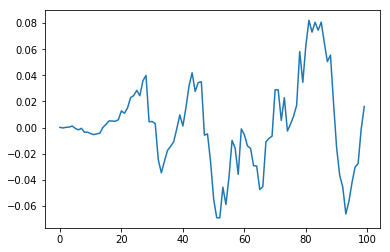

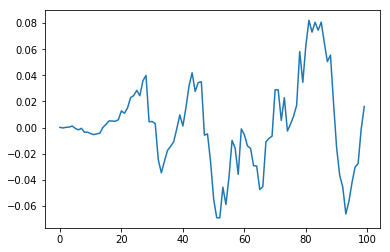

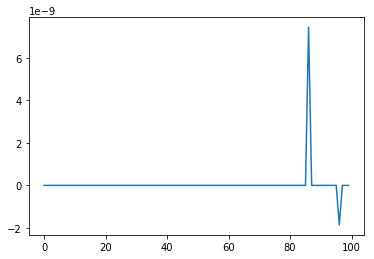

In [27]:
a1 = get_feature(datum_3, 'audio')
a2 = get_feature(datum_4, 'audio')
plt.plot(a1[:100])
plt.figure()
plt.plot(a2[:100])
plt.figure()
plt.plot(a1[:100]-a2[:100])

In [70]:
def merge_n_samples_at_random(dataset, n, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    # TODO find some other way of randomization without duplicates
    # if np doesn't have anything, rejection sampling with a set is fine
    idxs = np.random.permutation(range(len(dataset)))[:n]
    print(idxs)
    data = dataset[idxs]
    
    datum = functools.reduce(merge_audio, data)
    return datum
    

In [101]:
audio = merge_n_samples_at_random(data, 5)
example_to_audio(audio)

[ 775 1602 3492  962 1809]
